### Imports

In [1]:
from keras.layers import Conv2D, MaxPool2D, Bidirectional,AveragePooling2D, LSTM, Reshape ,Input, BatchNormalization, MaxPooling2D, Activation, Flatten, Dense, Dropout
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, TensorBoard
from sklearn.metrics import confusion_matrix, classification_report
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.model_selection import train_test_split
from keras.models import Sequential, load_model
from keras.preprocessing import image
from keras.utils import np_utils
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
import seaborn as sns
import seaborn as sn
import pandas as pd 
import numpy as np
import scipy
import cv2

### Exploratory Data Analysis

Reading data

In [2]:
data_path ="D://Everything/Development Setup/fer2013.csv"
data = pd.read_csv(data_path)
data

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training
...,...,...,...
35882,6,50 36 17 22 23 29 33 39 34 37 37 37 39 43 48 5...,PrivateTest
35883,3,178 174 172 173 181 188 191 194 196 199 200 20...,PrivateTest
35884,0,17 17 16 23 28 22 19 17 25 26 20 24 31 19 27 9...,PrivateTest
35885,3,30 28 28 29 31 30 42 68 79 81 77 67 67 71 63 6...,PrivateTest


The dataset consists of 35887 instances which are divided as follows: 

In [3]:
instanceCount = data.groupby('Usage').size()
instanceCount

Usage
PrivateTest     3589
PublicTest      3589
Training       28709
dtype: int64

In [4]:
emotions = {0:"Angry", 1:"Disgust", 2:"Fear", 3:"Happy", 4:"Sad", 5:"Surprise", 6:"Neutral"}

Checking datatypes of the dataframe variables

In [5]:
data.dtypes

emotion     int64
pixels     object
Usage      object
dtype: object

These datatypes will be changed accordingly. The pixels variable should be an array of pixel values, the emotion variable should be categorical for the model to accept it.

In [6]:
# Checking null values in dataframe
data.isna().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no nulls in the dataframe.

let's check the duplicates within the dataframe. 

In [7]:
duplicates = data[data.duplicated(subset='pixels')]
duplicates

,emotion,pixels,Usage
675,5,255 255 255 255 255 255 255 237 217 146 185 11...,Training
718,2,114 95 82 84 85 120 108 97 83 64 68 85 80 86 1...,Training
1145,5,205 204 205 205 204 203 203 203 202 202 203 20...,Training
1266,3,201 218 246 178 74 62 63 78 85 83 71 65 64 67 ...,Training
1289,5,238 69 24 32 34 33 27 30 41 49 60 64 47 65 80 ...,Training
...,...,...,...
35826,2,200 201 199 197 198 199 199 198 197 196 194 19...,PrivateTest
35833,5,254 254 254 254 254 253 252 254 113 36 62 69 6...,PrivateTest
35874,5,43 43 51 73 94 97 102 95 99 107 126 144 154 17...,PrivateTest
35875,5,248 251 239 144 102 95 82 77 91 138 153 145 14...,PrivateTest


we can see that there is a total of 1853 duplicated images within the dataframe.

In some cases these duplicates could be beneficial to the model in other cases they will affect the model negatively when training. 

let's take a look at some of these duplicated images

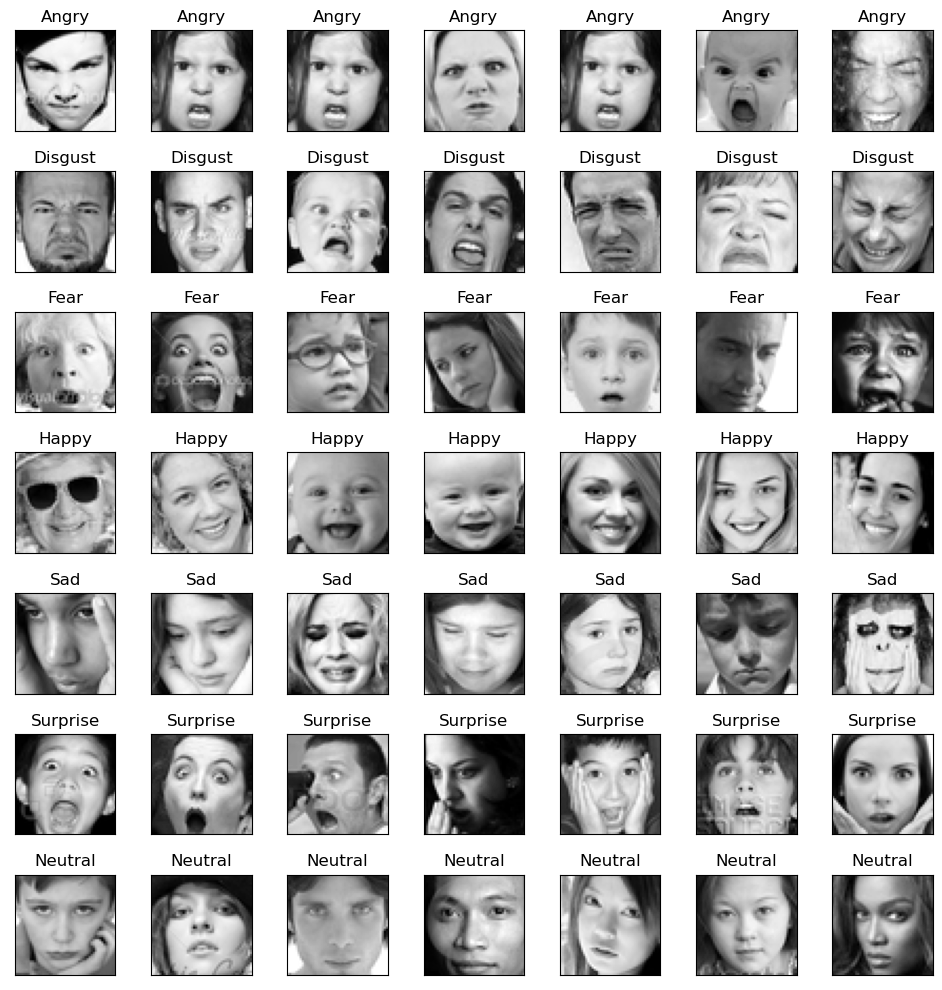

In [8]:
fig = plt.figure(1, (10, 10))

k = 0
for label in sorted(duplicates.emotion.unique()):
    for j in range(7):
        
        px = duplicates[duplicates.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')
        k += 1
        ax = plt.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotions[label])
        plt.tight_layout()

let's find out how many duplicates are within each of the emotions

In [9]:
pixel_counts = duplicates.groupby('emotion').size()
print("duplicated emotions: ", pixel_counts.sum()), print(pixel_counts)

duplicated emotions:  1853
emotion
0    226
1     87
2    301
3    193
4    155
5    745
6    146
dtype: int64


(None, None)

let's compare the duplicates of each emotion to the total number of instances within the same emotion.

for this visualization to happen a simple function will be created to see the total instances of each emotion compared to the total number for duplicates of each emotion.

In [10]:
 emotion_count = data.groupby('emotion').size()
 print("total emotions: ", emotion_count.sum()), print(emotion_count)

total emotions:  35887
emotion
0    4953
1     547
2    5121
3    8989
4    6077
5    4002
6    6198
dtype: int64


(None, None)

In [11]:
def Total_diff(data, duplicates, xtitle, lbl):

    duplic = duplicates.groupby('emotion').size()
    total = data.groupby('emotion').size()

    # Create the bar plot
    fig, ax = plt.subplots()

    # Define the width of each bar
    bar_width = 0.25

    # Define the x-axis positions
    x = np.arange(len(emotions))

    # Plot the bars for total emotions
    ax.bar(x, total, width=bar_width-0.5, label='Total Emotions')

    # Plot the bars for duplicated emotions next to the total emotions
    ax.bar(x + bar_width, duplic, width=bar_width-0.5, label=lbl)

    # Add labels and title
    ax.set_xlabel('Emotion')
    ax.set_ylabel('Count')
    ax.set_title(xtitle)

    # Add x-axis tick labels
    ax.set_xticks(x + bar_width / 2)
    ax.set_xticklabels(emotions)

    # Add text labels for total emotion counts
    for i, count in enumerate(total):
        ax.text(i, count + 50, str(count), ha='center', va='bottom')

    # Add text labels for duplicated emotion counts
    for i, count in enumerate(duplic):
        ax.text(i + bar_width, count + 50, str(count), ha='center', va='bottom')

    # Add legend
    ax.legend()

    # Show the plot
    plt.show()


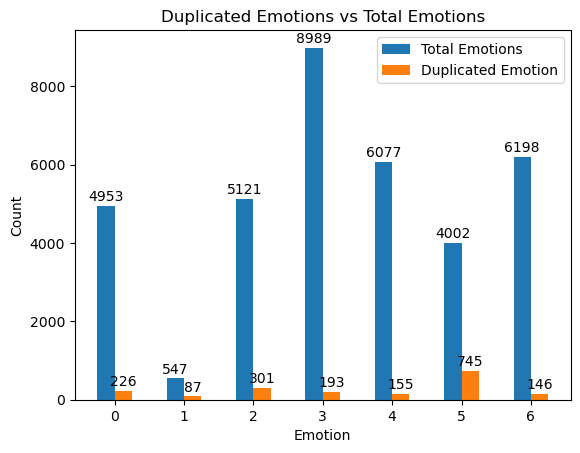

In [12]:
xtitle = "Duplicated Emotions vs Total Emotions"
label = "Duplicated Emotion"
Total_diff(data, duplicates, xtitle, label)

### Data Pre-procesing - getting data ready to train the model

For this dataset, a problem of imbalanced class is presented. 

Therefore three different techniques will be shown in this study which are Class_weight, Random OverSampling, Synthetic Minority Oversampling Technique
, and finally one model will be tested wihthout the use of any sampling techniques.

This Code implements ROS

In [55]:
def pre_proc_data(data):
    # Extract the pixel data and emotion labels from the input data
    x_data = data["pixels"]
    y_data = data["emotion"]

    # Use a RandomOverSampler to balance the classes by oversampling the minority classes
    oversampler = RandomOverSampler(sampling_strategy='auto')
    x_data = np.array(list(map(str.split, x_data)), np.float32)
    x_data, y_data = oversampler.fit_resample(np.array(x_data), y_data)
    
    # Normalize the pixel data by dividing all values by 255
    x_data /= 255

    # Reshape the pixel data into a 4D array of shape (num_samples, 48, 48, 1)
    x_data = x_data.reshape(-1, 48, 48, 1)

    # Convert the emotion labels to a 2D array of shape (num_samples, 1)
    y_data = np.array(y_data)
    y_data = y_data.reshape(y_data.shape[0], 1)

    # Split the data into training and testing sets
    x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.1, random_state=45)
    
    # Convert the emotion labels to one-hot encoded vectors
    y_train = np_utils.to_categorical(y_train, 7)
    y_test = np_utils.to_categorical(y_test, 7)
    
    # Return the processed data as a tuple of four arrays
    return x_train, x_test, y_train, y_test

x_train, x_test, y_train, y_test = pre_proc_data(data)


In [56]:
x_train, x_test, y_train, y_test = pre_proc_data(data)

Let's view some of the samples in x_train

In [57]:
def ViewPixelSample(data, RANGE, ydata=None):
    # Check if the input data is a Pandas DataFrame
    if isinstance(data, pd.DataFrame):
        # Extract the pixel data and emotion labels from the DataFrame
        xdata = data["pixels"]
        ydata = data["emotion"]
        # Define a dictionary to map emotion labels to their names
        emotions = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}
        # Loop over a range of images and display them with their emotion labels
        for ix in range(RANGE):
            # Create a new plot figure
            f = plt.figure(ix)
            # Set the width and height of the plot figure
            f.set_figwidth(5)
            f.set_figheight(2)
            # Remove ticks from the x and y axes
            plt.xticks([])
            plt.yticks([])
            # Set the xlabel to the name of the corresponding emotion label
            plt.xlabel(emotions[np.argmax(ydata[ix])])
            # Display the image with the corresponding pixel data
            plt.imshow(xdata[ix].reshape((48, 48)), interpolation='none', cmap='gray')
        # Show the plot
        plt.show()
    else:
        # Define a dictionary to map emotion labels to their names
        emotions = {0: "angry", 1: "disgust", 2: "fear", 3: "happy", 4: "neutral", 5: "sad", 6: "surprise"}
        # Convert ydata to a list if it is a NumPy array
        if isinstance(ydata, np.ndarray):
            ydata = ydata.tolist()
        # Loop over a range of images and display them with their emotion labels (if provided)
        for ix in range(RANGE):
            # Create a new plot figure
            f = plt.figure(ix)
            # Set the width and height of the plot figure
            f.set_figwidth(5)
            f.set_figheight(2)
            # Remove ticks from the x and y axes
            plt.xticks([])
            plt.yticks([])
            # Set the xlabel to the name of the corresponding emotion label (if provided)
            if ydata is not None:
                plt.xlabel(emotions[np.argmax(ydata[ix])])
            # Display the image with the corresponding pixel data
            plt.imshow(data[ix].reshape((48, 48)), interpolation='none', cmap='gray')
        # Show the plot
        plt.show()


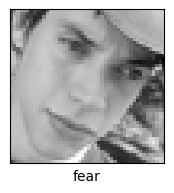

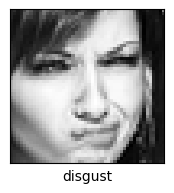

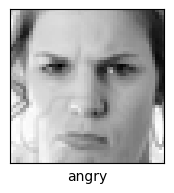

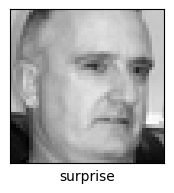

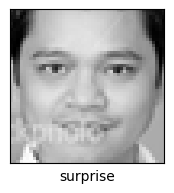

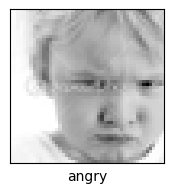

In [58]:
ViewPixelSample(x_train, 6, y_train)

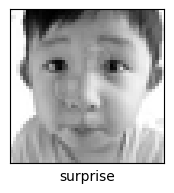

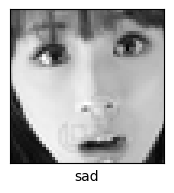

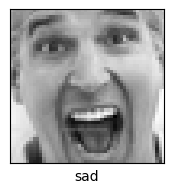

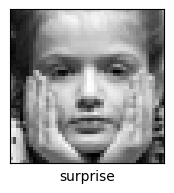

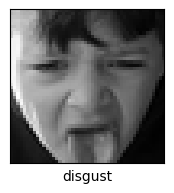

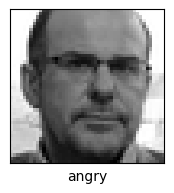

In [59]:
ViewPixelSample(x_test, 6, y_test)

### Model Architecture 

In [60]:
def Cnn_Lstm_model():

    model = Sequential([

    Input((48, 48, 1)),
    
    Conv2D(32, kernel_size=(3,3), strides=(1,1), padding='valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(64, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(64, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    
    Conv2D(128, (3,3), strides=(1,1), padding = 'same'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Conv2D(128, (3,3), strides=(1,1), padding = 'valid'),
    BatchNormalization(axis=3),
    Activation('relu'),
    MaxPooling2D((2,2)),
    
    Reshape((-1,128)),
    (LSTM(128)),

    (Reshape((-1,64))),
    LSTM(64),

    Dense(200, activation='relu'),
    Dropout(0.6),

    Dense(7, activation = 'softmax')
    
    ])

    keras.utils.plot_model(model, to_file = "CNN_LSTM_model.png", show_shapes = True, show_dtype = True)

    model.summary()
    return model

In [61]:
model = Cnn_Lstm_model()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 46, 46, 32)        320       
                                                                 
 batch_normalization_5 (Batc  (None, 46, 46, 32)       128       
 hNormalization)                                                 
                                                                 
 activation_5 (Activation)   (None, 46, 46, 32)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 46, 46, 64)        18496     
                                                                 
 batch_normalization_6 (Batc  (None, 46, 46, 64)       256       
 hNormalization)                                                 
                                                                 
 activation_6 (Activation)   (None, 46, 46, 64)       

### Defining Callbacks

In [62]:
lr_reduce = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.1, 
    mid_delta=0.0001, 
    patience=1, 
    verbose=1
)

Earlystop = EarlyStopping(
    monitor='val_loss',
    patience=8,
    verbose =1,
)

TensBoard = TensorBoard(
    log_dir = 'logs-F_CNN_LSTM'
)

checkpoint = ModelCheckpoint(
    filepath = 'F_CNN_LSTM.h5',
    verbose = 1,
    save_best_only = True
)

### Compiling and model Fitting

In [63]:
epochs = 100
adam = keras.optimizers.Adam(learning_rate=0.0002)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [64]:
history = model.fit(x_train, y_train, epochs = epochs,validation_data=(x_test, y_test), callbacks = [lr_reduce, Earlystop, TensBoard, checkpoint])

Epoch 1/100
1770/1770 [==============================] - ETA: 0s - loss: 1.4453 - accuracy: 0.4371
Epoch 1: val_loss improved from inf to 1.17917, saving model to F_CNN_LSTM.h5
1770/1770 [==============================] - 38s 16ms/step - loss: 1.4453 - accuracy: 0.4371 - val_loss: 1.1792 - val_accuracy: 0.5389 - lr: 2.0000e-04
Epoch 2/100
1770/1770 [==============================] - ETA: 0s - loss: 1.0518 - accuracy: 0.5954
Epoch 2: val_loss improved from 1.17917 to 1.04678, saving model to F_CNN_LSTM.h5
1770/1770 [==============================] - 29s 16ms/step - loss: 1.0518 - accuracy: 0.5954 - val_loss: 1.0468 - val_accuracy: 0.5929 - lr: 2.0000e-04
Epoch 3/100
1767/1770 [============================>.] - ETA: 0s - loss: 0.9030 - accuracy: 0.6626
Epoch 3: val_loss improved from 1.04678 to 0.91539, saving model to F_CNN_LSTM.h5
1770/1770 [==============================] - 27s 15ms/step - loss: 0.9030 - accuracy: 0.6626 - val_loss: 0.9154 - val_accuracy: 0.6579 - lr: 2.0000e-04
Epoch

### Evaluation of the model

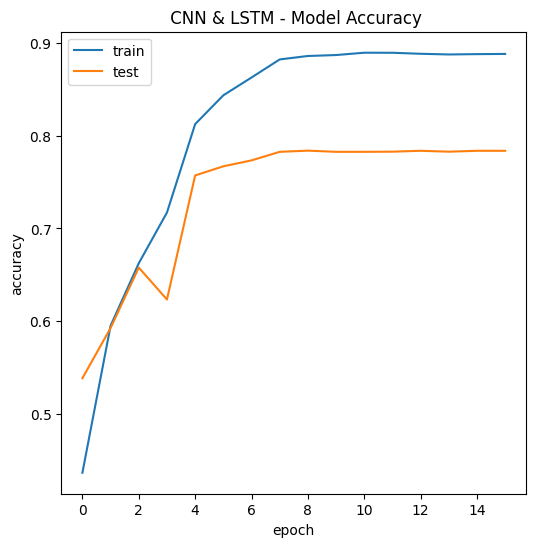

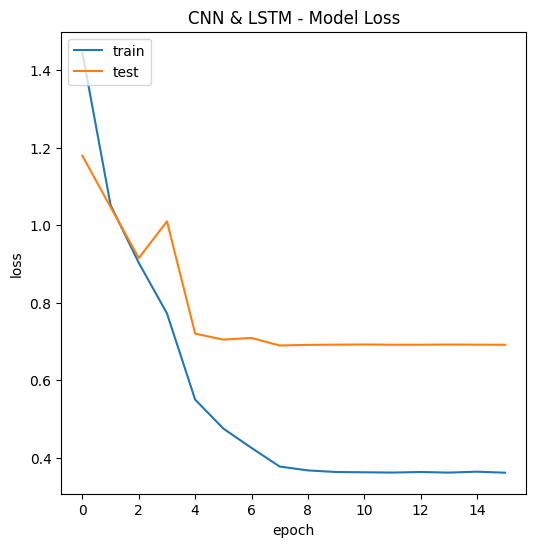

In [65]:
acc = plt.figure(figsize = (6,6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title(' CNN & LSTM - Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
acc.savefig("ACC-CNN-LSTM")
plt.show()

loss = plt.figure(figsize = (6,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN & LSTM - Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
loss.savefig("LOSS-CNN-LSTM")
plt.show()

In [66]:
%load_ext tensorboard 

In [67]:
print("Accuracy of our model on validation data : " , model.evaluate(x_test, y_test)[1]*100 , "%")

197/197 [==============================] - 1s 5ms/step - loss: 0.6916 - accuracy: 0.7836
Accuracy of our model on validation data :  78.35690379142761 %


In [68]:
y_pred = model.predict(x_test)
y_result = []

for pred in y_pred:
    y_result.append(np.argmax(pred))
y_result[:10]

197/197 [==============================] - 2s 4ms/step


[6, 5, 0, 6, 1, 0, 3, 4, 1, 3]

In [69]:
y_actual = []

for pred in y_test:
    y_actual.append(np.argmax(pred))
y_actual[:10]

[6, 5, 5, 6, 1, 0, 3, 4, 1, 3]

In [70]:
print(classification_report(y_actual, y_result))

              precision    recall  f1-score   support

           0       0.75      0.74      0.75       935
           1       1.00      1.00      1.00       895
           2       0.71      0.71      0.71       880
           3       0.83      0.80      0.81       906
           4       0.59      0.65      0.62       888
           5       0.93      0.92      0.92       869
           6       0.70      0.68      0.69       920

    accuracy                           0.78      6293
   macro avg       0.79      0.78      0.79      6293
weighted avg       0.79      0.78      0.78      6293



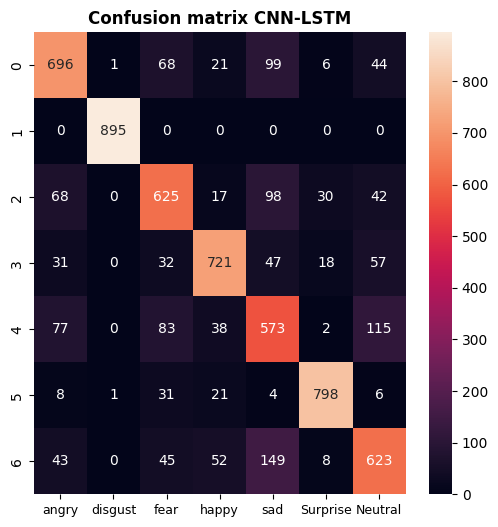

In [71]:
cm =  tf.math.confusion_matrix(labels = y_actual, predictions = y_result)


plt.figure(figsize = (6,6))
ax = plt.axes()
sn.heatmap(cm, annot = True, fmt = 'd')

ax.xaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"], fontsize=9);
ax.xaxis.set_ticklabels(['angry', 'disgust',"fear", "happy", "sad", "Surprise", "Neutral"], fontsize=9);


plt.title('Confusion matrix CNN-LSTM', fontsize = 12, fontweight=700)


plt.savefig("ConfMat-CNN_LSTM")

### Saliency Map

In [72]:
def display_samples_and_saliency_maps(model, x_data, y_data, num_samples_per_emotion=1):
    emotion_labels = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise','Neutral']
    samples_per_emotion = {label: 0 for label in emotion_labels}

    for i in range(len(x_data)):
        actual_emotion_index = np.argmax(y_data[i])
        actual_emotion_label = emotion_labels[actual_emotion_index]

        if samples_per_emotion[actual_emotion_label] >= num_samples_per_emotion:
            if all([count >= num_samples_per_emotion for count in samples_per_emotion.values()]):
                break
            else:
                continue

        samples_per_emotion[actual_emotion_label] += 1
        original_image = x_data[i]

        # Load image from array and normalize
        image = np.squeeze(original_image)
        image = cv2.resize(image, (48, 48))
        if image.ndim == 2:
            image = np.expand_dims(image, axis=-1)
        image = np.expand_dims(image, axis=0)
        processed_image = image / 255.0

        # Compute saliency map
        img_tensor = tf.convert_to_tensor(processed_image, dtype=tf.float32)
        with tf.GradientTape() as tape:
            tape.watch(img_tensor)
            predictions = model(img_tensor)
            top_class_idx = tf.argmax(predictions[0])
            top_class_output = predictions[:, top_class_idx]
        grads = tape.gradient(top_class_output, img_tensor)
        saliency_map = np.max(np.abs(grads), axis=-1)[0]

        # Visualize saliency map with actual emotion
        if original_image.ndim == 3 and original_image.shape[-1] == 1:
            original_image = np.squeeze(original_image)

        plt.figure(figsize=(8, 5))
        plt.subplot(1, 2, 1)
        plt.imshow(original_image, cmap='gray' if original_image.ndim == 2 else None)
        plt.title(f"Original Image")
        plt.xlabel(f"Emotion: {actual_emotion_label}")

        plt.subplot(1, 2, 2)
        plt.imshow(saliency_map, cmap='inferno')
        plt.title("Saliency Map")
        plt.show()


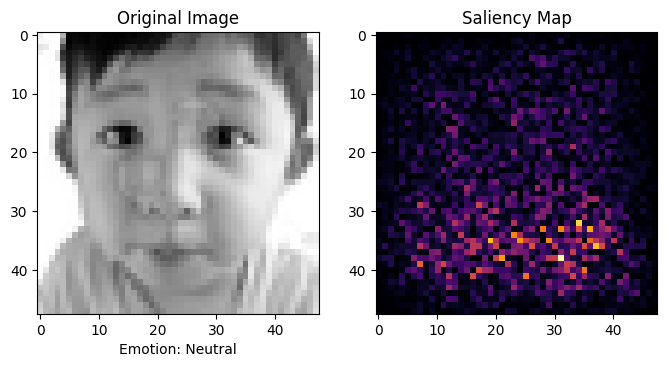

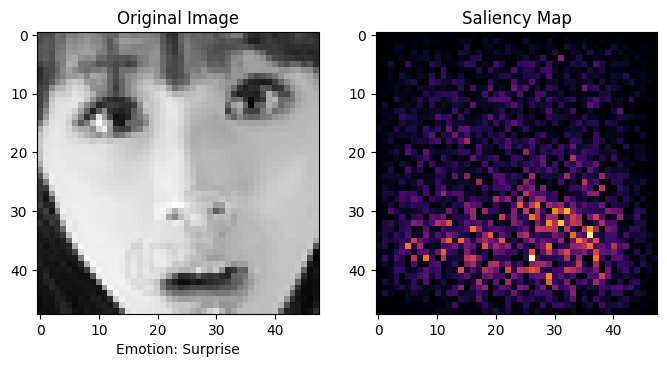

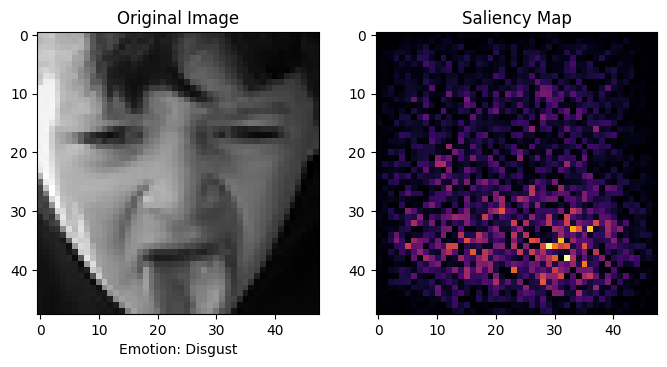

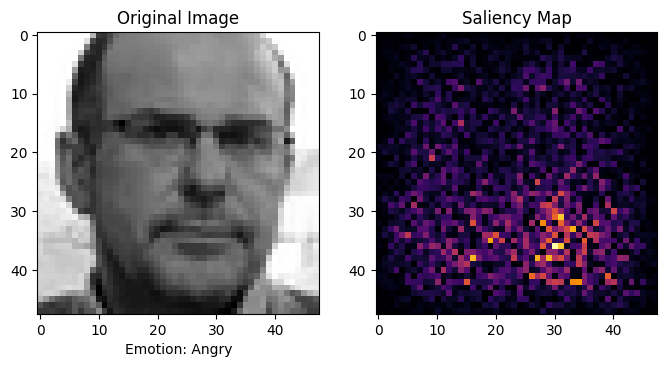

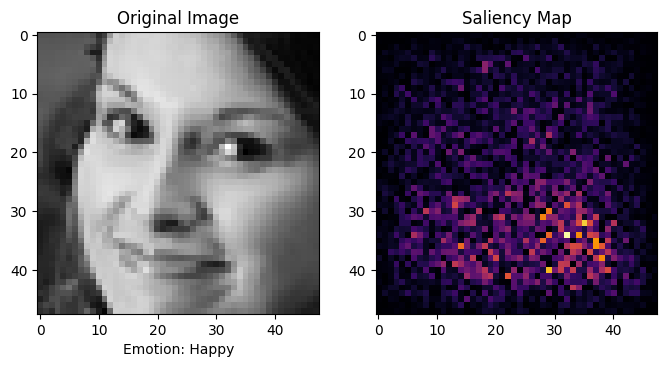

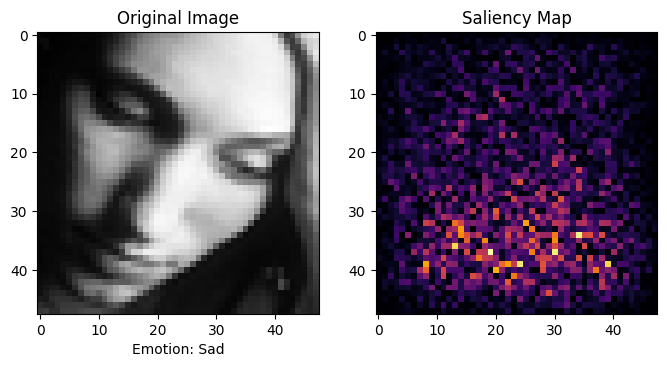

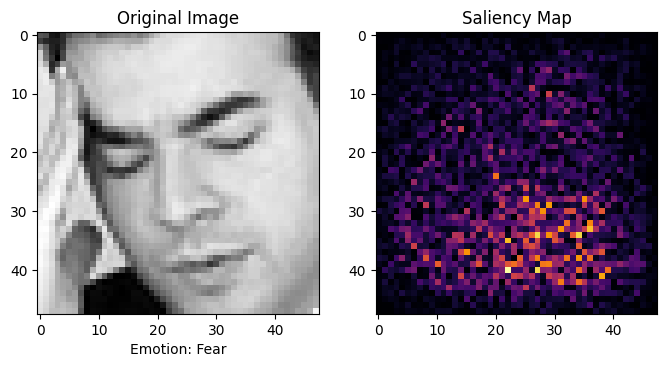

In [73]:
display_samples_and_saliency_maps(model, x_test, y_test)